Đã đọc dữ liệu: 19684 dòng, 18 cột
Các cột có: ['id', 'Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', '0be1dad']

Sử dụng cột '0be1dad' làm biến target

Entropy của target (0be1dad): 2.7774
Các nhãn target: ['0rmal_Weight' 'Insufficient_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
Phân phối target: {'0rmal_Weight': 3062, 'Insufficient_Weight': 2516, 'Obesity_Type_I': 2418, 'Obesity_Type_II': 3064, 'Obesity_Type_III': 4046, 'Overweight_Level_I': 2275, 'Overweight_Level_II': 2303}

KẾT QUẢ PHÂN TÍCH MỨC ĐỘ ẢNH HƯỞNG ĐẾN BÉO PHÌ
Biến                                Info Gain    H(Y|X)       Weight       % Ảnh hưởng 
--------------------------------------------------------------------------------
Gender                              0.3907       2.3866       0.0706       7.06        %
Age                                 0.

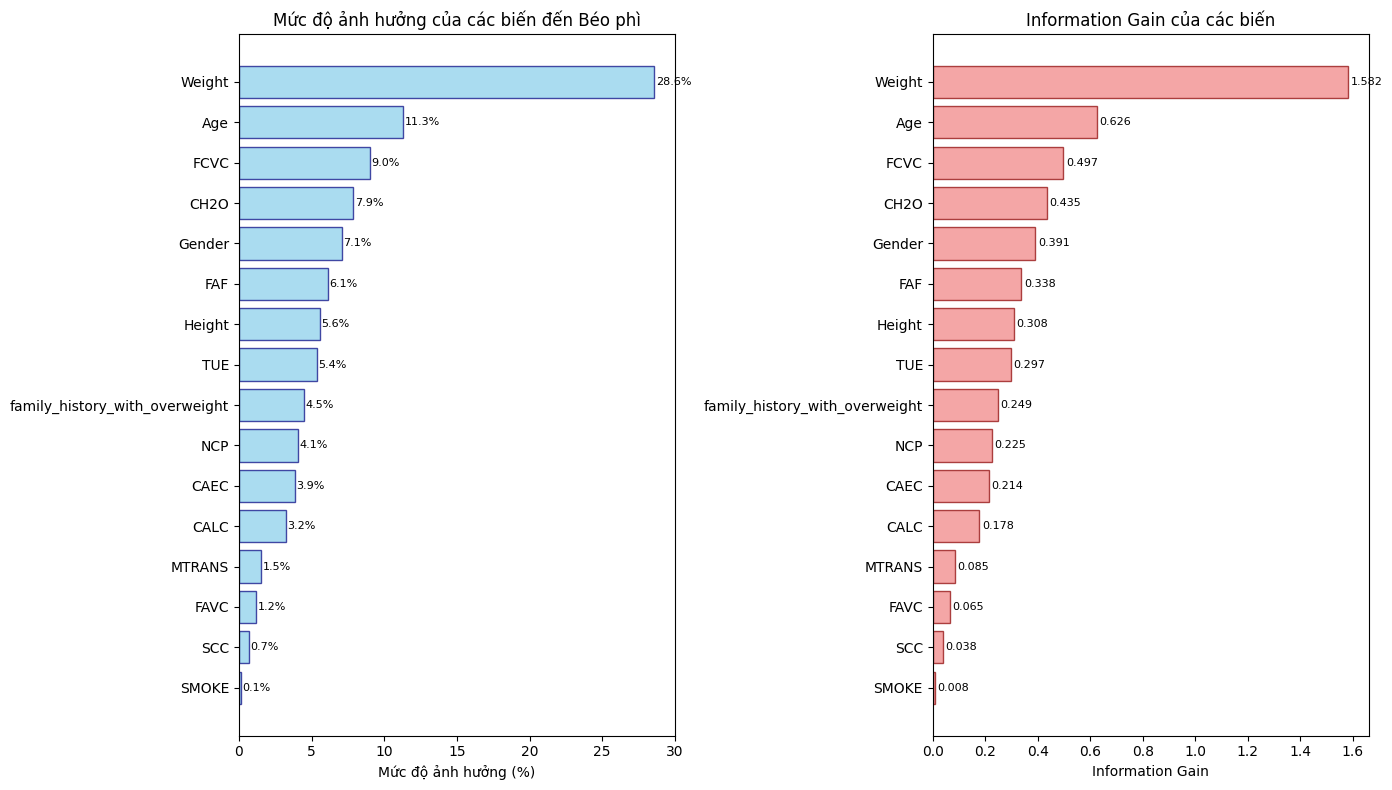


Đã lưu kết quả vào: obesity_influence_analysis.csv


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_conditional_entropy(feature_values, target_values):
    """
    Tính conditional entropy H(Y|X) - entropy của target khi biết feature
    """
    # Tạo bảng contingency
    unique_features = np.unique(feature_values)
    conditional_entropy = 0
    total_count = len(target_values)
    
    for feature_val in unique_features:
        # Lấy các giá trị target tương ứng với feature_val
        mask = feature_values == feature_val
        target_subset = target_values[mask]
        
        if len(target_subset) == 0:
            continue
            
        # Tính probability của feature_val
        p_feature = len(target_subset) / total_count
        
        # Tính entropy của target trong subset này
        target_counts = np.bincount(target_subset)
        target_probs = target_counts / len(target_subset)
        target_probs = target_probs[target_probs > 0]  # Loại bỏ probability 0
        
        if len(target_probs) > 1:
            subset_entropy = entropy(target_probs, base=2)
        else:
            subset_entropy = 0  # Hoàn toàn pure
            
        conditional_entropy += p_feature * subset_entropy
    
    return conditional_entropy

def calculate_information_gain_weights(data, target_column):
    """
    Tính trọng số dựa trên Information Gain cho việc dự đoán target
    
    Parameters:
    data: DataFrame chứa dữ liệu
    target_column: tên cột target (biến phụ thuộc)
    
    Returns:
    weights: dict chứa trọng số cho mỗi biến
    """
    
    # Danh sách 16 biến đầu vào
    input_variables = [
        'Gender', 'Age', 'Height', 'Weight', 
        'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 
        'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'
    ]
    
    # Biến nominal (0,1)
    nominal_vars = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
    
    # Encode target variable
    le_target = LabelEncoder()
    target_encoded = le_target.fit_transform(data[target_column].dropna())
    
    # Tính entropy của target (H(Y))
    target_counts = np.bincount(target_encoded)
    target_probs = target_counts / len(target_encoded)
    target_entropy = entropy(target_probs, base=2)
    
    print(f"Entropy của target ({target_column}): {target_entropy:.4f}")
    print(f"Các nhãn target: {le_target.classes_}")
    print(f"Phân phối target: {dict(zip(le_target.classes_, target_counts))}\n")
    
    information_gains = {}
    conditional_entropies = {}
    
    for var in input_variables:
        if var not in data.columns:
            print(f"Cảnh báo: Không tìm thấy cột {var}")
            continue
            
        # Lọc dữ liệu hợp lệ
        valid_mask = data[var].notna() & data[target_column].notna()
        feature_values = data.loc[valid_mask, var]
        target_values_subset = data.loc[valid_mask, target_column]
        
        if len(feature_values) == 0:
            information_gains[var] = 0
            conditional_entropies[var] = target_entropy
            continue
        
        if var in nominal_vars or data[var].dtype in ['object', 'category']:
            # Xử lý biến categorical/nominal
            if var not in nominal_vars and data[var].dtype not in ['object', 'category']:
                # Biến liên tục - chia thành bins
                n_bins = min(10, len(feature_values.unique()))
                if n_bins > 1:
                    try:
                        feature_binned = pd.cut(feature_values, bins=n_bins, duplicates='drop')
                        le_feature = LabelEncoder()
                        feature_encoded = le_feature.fit_transform(feature_binned.astype(str))
                    except:
                        feature_encoded = np.zeros(len(feature_values))
                else:
                    feature_encoded = np.zeros(len(feature_values))
            else:
                # Biến categorical
                le_feature = LabelEncoder()
                feature_encoded = le_feature.fit_transform(feature_values.astype(str))
        else:
            # Biến liên tục - chia thành bins
            n_bins = min(10, len(feature_values.unique()))
            if n_bins > 1:
                try:
                    feature_binned = pd.cut(feature_values, bins=n_bins, duplicates='drop')
                    le_feature = LabelEncoder()
                    feature_encoded = le_feature.fit_transform(feature_binned.astype(str))
                except:
                    feature_encoded = np.zeros(len(feature_values))
            else:
                feature_encoded = np.zeros(len(feature_values))
        
        # Encode target subset
        target_encoded_subset = le_target.transform(target_values_subset)
        
        # Tính conditional entropy H(Y|X)
        cond_entropy = calculate_conditional_entropy(feature_encoded, target_encoded_subset)
        conditional_entropies[var] = cond_entropy
        
        # Tính Information Gain = H(Y) - H(Y|X)
        info_gain = target_entropy - cond_entropy
        information_gains[var] = max(0, info_gain)  # Đảm bảo không âm
    
    # Tính trọng số dựa trên Information Gain
    total_info_gain = sum(information_gains.values())
    
    weights = {}
    for var in input_variables:
        if var in information_gains:
            if total_info_gain > 0:
                weights[var] = information_gains[var] / total_info_gain
            else:
                weights[var] = 1 / len(input_variables)
        else:
            weights[var] = 0
    
    return weights, information_gains, conditional_entropies, target_entropy

def print_detailed_results(weights, information_gains, conditional_entropies, target_entropy):
    """In kết quả chi tiết"""
    
    print("="*80)
    print("KẾT QUẢ PHÂN TÍCH MỨC ĐỘ ẢNH HƯỞNG ĐẾN BÉO PHÌ")
    print("="*80)
    
    print(f"{'Biến':<35} {'Info Gain':<12} {'H(Y|X)':<12} {'Weight':<12} {'% Ảnh hưởng':<12}")
    print("-"*80)
    
    for var in weights.keys():
        if var in information_gains:
            pct_influence = weights[var] * 100
            print(f"{var:<35} {information_gains[var]:<12.4f} {conditional_entropies[var]:<12.4f} {weights[var]:<12.4f} {pct_influence:<12.2f}%")
    
    print("-"*80)
    print(f"{'TỔNG':<35} {sum(information_gains.values()):<12.4f} {'':<12} {sum(weights.values()):<12.4f} {'100.00%':<12}")
    print("="*80)
    
    # Sắp xếp theo mức độ ảnh hưởng
    sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nXẾP HẠNG MỨC ĐỘ ẢNH HƯỞNG ĐẾN BÉO PHÌ:")
    print("-"*50)
    for i, (var, weight) in enumerate(sorted_weights, 1):
        if var in information_gains:
            pct = weight * 100
            gain = information_gains[var]
            print(f"{i:2d}. {var:<30} {pct:6.2f}% (IG: {gain:.4f})")
    
    print(f"\nGiải thích:")
    print(f"- Information Gain (IG): Lượng thông tin mà biến cung cấp để dự đoán béo phì")
    print(f"- H(Y|X): Entropy còn lại của béo phì khi biết giá trị của biến")
    print(f"- Weight: Tỷ trọng ảnh hưởng của biến (tổng = 100%)")
    print(f"- IG càng cao = ảnh hưởng càng mạnh đến kết quả béo phì")

def visualize_results(weights, information_gains):
    """Tạo biểu đồ trực quan"""
    
    # Sắp xếp theo trọng số
    sorted_data = sorted(weights.items(), key=lambda x: x[1], reverse=True)
    variables = [item[0] for item in sorted_data]
    weight_values = [item[1] * 100 for item in sorted_data]  # Chuyển thành %
    
    plt.figure(figsize=(14, 8))
    
    # Subplot 1: Trọng số ảnh hưởng
    plt.subplot(1, 2, 1)
    bars = plt.barh(variables, weight_values, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.xlabel('Mức độ ảnh hưởng (%)')
    plt.title('Mức độ ảnh hưởng của các biến đến Béo phì')
    plt.gca().invert_yaxis()
    
    # Thêm giá trị trên thanh
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center', fontsize=8)
    
    # Subplot 2: Information Gain
    plt.subplot(1, 2, 2)
    ig_values = [information_gains.get(var, 0) for var in variables]
    bars2 = plt.barh(variables, ig_values, color='lightcoral', edgecolor='darkred', alpha=0.7)
    plt.xlabel('Information Gain')
    plt.title('Information Gain của các biến')
    plt.gca().invert_yaxis()
    
    # Thêm giá trị trên thanh
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('obesity_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    try:
        # Đọc dữ liệu
        data = pd.read_csv('obesity_level.csv')
        
        print(f"Đã đọc dữ liệu: {data.shape[0]} dòng, {data.shape[1]} cột")
        print(f"Các cột có: {list(data.columns)}\n")
        
        # Xác định cột target (biến phụ thuộc về béo phì)
        target_column = None
        possible_targets = ['0be1dad', 'obesity_level', 'NObeyesdad', 'target', 'label']
        
        for col in possible_targets:
            if col in data.columns:
                target_column = col
                break
        
        if target_column is None:
            print("Không tìm thấy cột target. Vui lòng chỉ định tên cột chứa kết quả béo phì:")
            target_column = input("Nhập tên cột target: ").strip()
        
        print(f"Sử dụng cột '{target_column}' làm biến target\n")
        
        # Tính entropy weights dựa trên ảnh hưởng đến target
        weights, info_gains, cond_entropies, target_entropy = calculate_information_gain_weights(data, target_column)
        
        # In kết quả chi tiết
        print_detailed_results(weights, info_gains, cond_entropies, target_entropy)
        
        # Tạo biểu đồ
        visualize_results(weights, info_gains)
        
        # Lưu kết quả
        results_df = pd.DataFrame({
            'Variable': list(weights.keys()),
            'Information_Gain': [info_gains.get(var, 0) for var in weights.keys()],
            'Conditional_Entropy': [cond_entropies.get(var, 0) for var in weights.keys()],
            'Weight': list(weights.values()),
            'Influence_Percentage': [w * 100 for w in weights.values()]
        })
        
        results_df = results_df.sort_values('Weight', ascending=False)
        results_df.to_csv('obesity_influence_analysis.csv', index=False)
        print(f"\nĐã lưu kết quả vào: obesity_influence_analysis.csv")
        
        return weights, info_gains
        
    except FileNotFoundError:
        print("Lỗi: Không tìm thấy file 'obesity_level.csv'")
        return None, None
    except Exception as e:
        print(f"Lỗi: {str(e)}")
        return None, None

# Chạy phân tích
if __name__ == "__main__":
    weights, info_gains = main()